# Welcome to point source imaging with cosipy-classic
In this notebook, we'll use a Richardson-Lucy deconvolution algorithm to image four point sources: the Crab, Cyg X-1, Cen A, and Vela. This analysis requires significant computer memory (>50 GB), so you may want to use a more resource-intensive computer for this work. Please refer to the README for additional information on each step of the analysis.

## Import packages
We will need to import the cosipy-classic functions from COSIpy_dc1.py, response_dc1, and COSIpy_tools_dc1, as well as some other standard Python packages

In [1]:
from COSIpy_dc1 import *
import response_dc1
from COSIpy_tools_dc1 import *

import pickle
import pystan

Welcome to JupyROOT 6.24/06


/Users/ckierans/Software/COSItools/COSItools/external/root_v6.24.06/lib/ROOT/_facade.py:150: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  return _orig_ihook(name, *args, **kwds)


## Define file names
The 'Point_sources_10x_BG.tra.gz' file contains simulations of all four point sources, each at 10X their true flux, and Ling background. This is our data file.

You can optionally image only the point sources (without background) by changing this file to point source-only simulation. You will have to adjust the RL algorithm parameters later in the notebook.

In [2]:
data_dir = '../data_products' # directory containing data & response files
filename = 'Point_sources_10x_BG.tra.gz' # combined simulation
response_filename = data_dir + '/Continuum_Response.npz' # detector response
background_filename = data_dir + '/Scaled_Ling_BG_1x.npz' # background response
background_mode = 'from file'

## Read simulation and define analysis object
Read in the data set and create the main cosipy-classic “analysis1" object, which provides various functionalities to study the specified file. This cell usually takes a few minutes to run.

In [3]:
analysis1 = COSIpy(data_dir, filename)
analysis1.read_COSI_DataSet()

# Bin the data and generate the light curve and spectrum

## Bin the data
Calling "get_binned_data()" may take several minutes, depending on the size of the dataset and the number of bins. Keep an eye on memory here: if your time bins are very small, for example, this could be an expensive operation.

As currently written, "get_binned_data()" uses about **16 GB memory.**

In [4]:
#Define the bin sizes
Delta_T = 1800 # time bin size in seconds
energy_bin_edges = np.array([150, 220, 325, 480, 520, 765, 1120, 1650, 2350, 3450, 5000]) # as defined in the response
pixel_size = 6. # as defined in the respoonse

analysis1.dataset.time_binning_tags(time_bin_size=Delta_T) # time binning
analysis1.dataset.init_binning(energy_bin_edges=energy_bin_edges, pixel_size=pixel_size) # energy and pixel binning
analysis1.dataset.get_binned_data() # bin data

## Examine the shape of the binned data.
The binned data are contained in "analysis1.dataset.binned_data." This is a 4-dimensional object representing the 5 dimensions of the Compton data space: (time, energy, $\phi$, FISBEL).

The number of bins in each dimension are shown by calling "shape."

In [5]:
print("time, energy, phi, fisbel")
print(analysis1.dataset.binned_data.shape)

time, energy, phi, fisbel
(2240, 10, 30, 1145)


In [6]:
# Can print the number of time bins, the width of each time bin, and the total time
print(analysis1.dataset.times.n_time_bins)
print(analysis1.dataset.times.times_wid)
print(analysis1.dataset.times.total_time)

2240
[900.         900.         900.         ... 900.         900.
 898.20636392]
4031996.412727833


## Plot raw spectrum & light curve

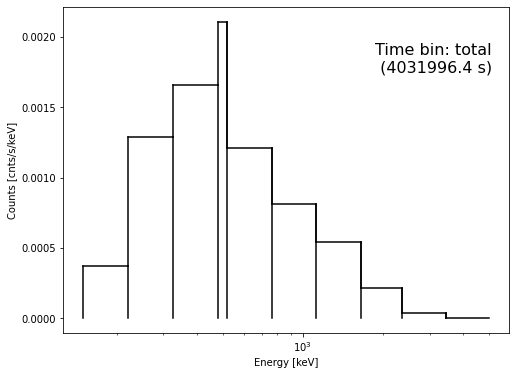

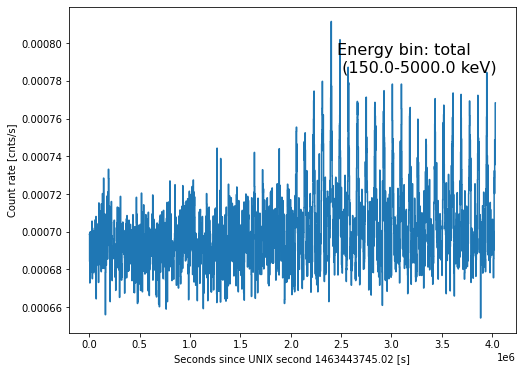

In [7]:
analysis1.dataset.plot_raw_spectrum()
plt.xscale('log')

analysis1.dataset.plot_lightcurve()

# Define the pointing object with the cosipy pointing class.
This may also take several minutes to run.

In [8]:
# definition of poitings (balloon stability + Earth rotation)
pointing1 = Pointing(dataset=analysis1.dataset,)

## Visualize the path of the Crab through the field-of-view.
This isn't necessary for the imaging algorithm, but is illustrative in the case of a point source. Take the Crab as an example.

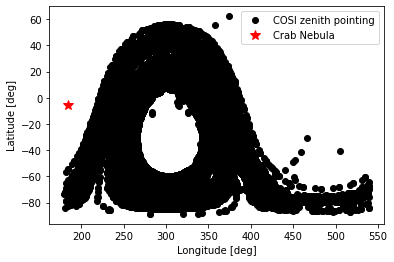

In [10]:
l_crab, b_crab = 184.55746, -5.78436 # Location of the Crab in Galactic coordinates [deg]

source = 'Crab Nebula'

plt.plot(pointing1.zpoins[:,0]+360, pointing1.zpoins[:,1], 'ko', label='COSI zenith pointing')
plt.plot(l_crab, b_crab, '*r', markersize=10 , label=f'{source}')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.legend();

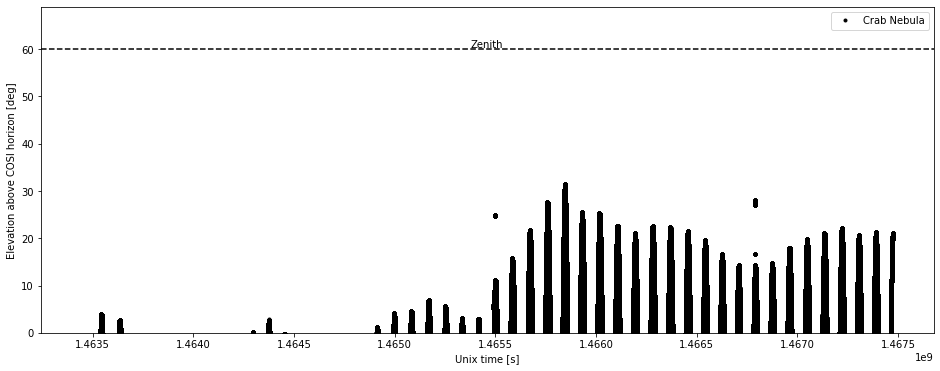

In [12]:
# COSI's field of view extends ~60 deg from zenith, hence why the Zenith is labeled as +60 deg above the horizon
analysis1.plot_elevation([l_crab], [b_crab], [f'{source}'])

# Define the BG model

In [13]:
# Ling BG simulation to model atmospheric background
background1 = BG(dataset=analysis1.dataset,mode=background_mode,filename=background_filename)

Using background mode: from file


# Read in the response

In [ ]:
# continuum response
rsp = response_dc1.SkyResponse(filename=response_filename,pixel_size=pixel_size) # read in detector response

Reading complete continuum response. This might take a while...
Done.

Creating general RMF matrices, stay tuned...


Loop over phi bins::   0%|          | 0/30 [00:00<?, ?it/s]

Done.

Creating general IRF. Wait for it...


## Exploring the shape of the data space
The shape of the response spans (Galactic latitude $b$, Galactic longitude $\ell$, Compton scattering angle $\phi$,  FISBEL, energy).The shape of the data and background objects span (time, energy, Compton scattering angle, FISBEL).

In [ ]:
rsp.rsp.response_grid_normed_efinal.shape

In [ ]:
np.shape(analysis1.dataset.binned_data)

In [ ]:
np.shape(background1.bg_model)

# Imaging Setup

## Define a grid on the sky to make images

In [39]:
# Convenient variable for deg --> radian conversion
deg2rad = np.pi/180.

# We define our sky-grid on a regular (pixel_size x pixel_size) grid for testing (later finer grid)
binsize = pixel_size

# Galactic coordiantes: l and b pixel edges
l_arrg = np.linspace(-180, 180, int(360/binsize)+1)
b_arrg = np.linspace(-90, 90, int(180/binsize)+1)

# Number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)

# Making a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg, b_arrg)

# Choosing the centre points as representative
l_arr = l_arrg[0:-1] + binsize/2
b_arr = b_arrg[0:-1] + binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr, b_arr)

# Define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR + binsize/2)) - np.sin(np.deg2rad(B_ARR - binsize/2)))

## Convert sky grid to zenith/azimuth pairs for all pointings

In [40]:
# calculate the zeniths and azimuths on that grid for all times
zensgrid,azisgrid = zenaziGrid(pointing1.ypoins[:,0], pointing1.ypoins[:,1],
                               pointing1.xpoins[:,0], pointing1.xpoins[:,1],
                               pointing1.zpoins[:,0], pointing1.zpoins[:,1],
                               L_ARR.ravel(), B_ARR.ravel())

In [41]:
# Reshape for next routines ... 
zensgrid = zensgrid.reshape(n_b, n_l, len(pointing1.xpoins))
azisgrid = azisgrid.reshape(n_b, n_l, len(pointing1.xpoins))

## Get observation indices for non-zero bins
Here we also chose an energy bin to image. Energy bin "2" in the continuum response (and, necessarily, "energy_bin_edges" at the beginning of the notebook) is $320-480$ keV. We choose this energy bin because it has the highest count rate. Refer to the energy spectrum generated earlier.

In [42]:
ebin = 2 # Analyzing 320-480 keV 
nonzero_idx = background1.calc_this[ebin]

## Reduce the response dimensions

In [44]:
sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
    n_b,
    n_l,
    analysis1.dataset.phis.n_phi_bins*\
    analysis1.dataset.fisbels.n_fisbel_bins, analysis1.dataset.energies.n_energy_bins)[:, :, nonzero_idx, ebin]

In [45]:
# reduced response dimensions:
# lat x lon x CDS
sky_response_CDS.shape

(30, 60, 2295)

## Function to get the response of an image for arbitrary time binning

In [43]:
def get_image_response_from_pixelhit_general(Response,zenith,azimuth,dt,n_hours,binsize=6,cut=60,altitude_correction=False,al=None):
    """
    Get Compton response from hit pixel for each zenith/azimuth vector(!) input.
    Binsize determines regular(!!!) sky coordinate grid in degrees.

    :param: zenith        Zenith positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :param: azimuth       Azimuth positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :option: binsize      Default 5 deg (matching the sky dimension of the response). If set
                          differently, make sure it matches the sky dimension as otherwise,
                          false results may be returned
    :option: cut          Threshold to cut the response calculation after a certain zenith angle.
                          Default 60
    :param: n_hours       Number of hours in cdxervation
    :option: altitude_correction Default False: use interpolated transmission probability, normalised to 33 km and 500 keV,
                          to modify number of expected photons as a function of altitude and zenith angle of cdxervation
    :option: al           Altitude values according to dt from construct_pointings(); used of altitude_correction is set to True
    """

    # assuming useful input:
    # azimuthal angle is periodic in the range [0,360[
    # zenith ranges from [0,180[

    # check which pixel (index) was hit on regular grid
    hit_pixel_zi = np.floor(zenith/binsize)
    hit_pixel_ai = np.floor(azimuth/binsize)

    # and which pixel centre
    hit_pixel_z = (hit_pixel_zi+0.5)*binsize
    hit_pixel_a = (hit_pixel_ai+0.5)*binsize

    # check which zeniths are beyond threshold
    bad_idx = np.where(hit_pixel_z > cut)

    # set hit pixels to output array
    za_idx = np.array([hit_pixel_zi,hit_pixel_ai]).astype(int)

    nz = zenith.shape[2]

    n_lon = int(360/binsize)
    n_lat = int(180/binsize)
    
    l_arrg = np.linspace(-180,180,int(360/binsize)+1)
    b_arrg = np.linspace(-90,90,int(180/binsize)+1)
    L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
    l_arr = l_arrg[0:-1]+binsize/2
    b_arr = b_arrg[0:-1]+binsize/2
    L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

    # take care of regular grid by applying weighting with latitude
    weights = ((binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights[bad_idx] = 0

    
    # check for negative weights and indices and remove
    weights[za_idx[0,:] < 0] = 0.
    weights[za_idx[1,:] < 0] = 0.
    za_idx[0,za_idx[0,:] < 0] = 0.
    za_idx[1,za_idx[1,:] < 0] = 0.
        
    
    if altitude_correction == True:
        altitude_response = return_altitude_response()
    else:
        altitude_response = one_func

    # get responses at pixels    
    image_response = np.zeros((n_hours,n_lat,n_lon,Response.shape[2]))

    for c in tqdm(range(n_hours)):
        cdx = np.where((pointing1.cdtpoins > analysis1.dataset.times.times_min[analysis1.dataset.times.n_ph_dx[c]]) &
                       (pointing1.cdtpoins <= analysis1.dataset.times.times_max[analysis1.dataset.times.n_ph_dx[c]]))[0]
    
        # this calculation is basically a look-up of the response entries. In general, weighting (integration) with the true shape can be introduced, however with a lot more computation time (Simpson's rule in 2D ...)
        image_response[c,:,:,:] += np.sum(Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:]*np.einsum('klij->iklj', weights[:,:,cdx,None])*dt[cdx,None,None,None],axis=0)#*altitude_weights[:,:,None]
        
    return image_response


## Calculate the general response for the current data set
This has to be done only once (for the data set).

Takes ~20 minutes to run and ~94 GB memory!

In [ ]:
cut = 90 # This mirrors the earth horizon cut in the response
sky_response_scaled = get_image_response_from_pixelhit_general(
    Response=sky_response_CDS,
    zenith=zensgrid,
    azimuth=azisgrid,
    dt=pointing1.dtpoins,
    n_hours=analysis1.dataset.times.n_ph,
    binsize=pixel_size,
    cut=cut,
    altitude_correction=False,
    al=np.ones(len(pointing1.dtpoins)))

In [ ]:
# data-set-specific response dimensions
# times x lat x lon x CDS
sky_response_scaled.shape

## Exposure map
i.e. the response weighted by time

In [ ]:
expo_map = np.zeros((n_b, n_l))

for i in tqdm(range(sky_response_scaled.shape[0])):
    expo_map += np.sum(sky_response_scaled[i,:,:,:], axis=2)
    
print(f'expo_map shape: {expo_map.shape}')

## Plotting the exposure map weighted with the pixel size

In [ ]:
plt.subplot(projection='aitoff')
p = plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.roll(expo_map/domega,axis=1,shift=0))
plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.roll(expo_map/domega,axis=1,shift=0),colors='black')
plt.colorbar(p, orientation='horizontal')

# Set up the RL algorithm

### Define regions of the sky that we actually cannot see

In [ ]:
# here we select everything, i.e. we have no bad exposure

bad_expo = np.where(expo_map/domega <= 0)

### Define function for a starting map for the RL deconvolution. We choose an isotropic map, i.e. all pixels on the sky are initialized with the same value

In [ ]:
def IsoMap(ll,bb,A0,binsize=pixel_size):
    shape = np.ones(ll.shape)
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

### Number of time bins (should be the first dimension of the response)

In [ ]:
d2h = n_time_bins 
d2h

### Select only one energy bin (as above) for data set

In [ ]:
print('ebin: ',ebin)
dataset = analysis1.dataset.binned_data[:,ebin,:,:].reshape(d2h,
                                                            analysis1.dataset.phis.n_phi_bins*analysis1.dataset.fisbels.n_fisbel_bins)[:,nonzero_idx]


### Same for background

In [ ]:
background_model = background1.bg_model_reduced[ebin]

### Check for consistency of data and background
They must have the same dimensions. If not, the algorithm won't work.

In [ ]:
dataset.shape,background_model.shape

### Define background model cuts, indices, and resulting number of cuts

In [ ]:
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts

### For the modified RL algorithm implemented here, we need to load a stan model that fits background plus two images (the current image plus a delta image given by the RL formalism)


In [ ]:
try:
    #read stanmodel.pkl (if already compiled)
    model_multimap = pickle.load(open('stanmodel.pkl', 'rb'))

except:
    print('Model not yet compiled, doing that now (might take a while).')
    
    # compile model (if not yet compiled):
    model_multimap = pystan.StanModel('stanmodel.stan')

    with open(data_dir + 'stanmodel.pkl', 'wb') as f:
        pickle.dump(model_multimap, f)


## Set an initial guess for the background amplitude
Feel free to play with this value, but here are suggestions informed by testing thus far:

### If source+BG:
We suggest setting "fitted_bg" to 0.9 or 0.99 when the loaded data/simulation (analysis1 object) contains both source and background. This is a rough estimate of the background contribution (90, 99%) to the entire data set.

### If analyzing source only:
When the analysis1 object does not contain background, we suggest setting this parameter to 1E-6, i.e. very close to zero background contribution.

In [ ]:
fitted_bg = np.array([0.9])


# Richardson-Lucy algorithm

## Individual steps are explained in code.
The steps follow the algorithm as outlined in [Knödlseder et al. 1999](https://ui.adsabs.harvard.edu/abs/1999A%26A...345..813K/abstract). Refer to that paper for a mathematical description of the algorithm.

The total memory used during these iterations is about 94 GB!! You might not be able to do much else with your machine while this is running. 

## Adjustable parameters
There are three parameters at the beginning of this RL cell which we encourage you to adjust. In fact, it is often necessary to adjust these parameters depending on the data being studied.

- map_init\
This is the flux value of the initial, isotropic map. Typically, a value of 0.01 works well. For stronger sources, you can try increasing it to 0.1 or 1.0. As an example, running the algorithm on a source-only (no BG) simulation of the Crab, Cen A, Cygnus X-1, and Vela works well with map_init = 0.01. However, when imaging these sources each simulated with 10X their true flux values, the algorithm fails at 0.01 and work when map_init = 1.0.

- iterations\
This is the number of RL iterations. You can set this to a small value, say 50, as you get used to using the algorithm. In our testing, though, for fully converged images we usually let the algorithm run for 150 iterations. ***This can take anywhere from several hours (usually simulations without background) to overnight (simulations with background) to run.***

- afl_scl\
This is a scaling factor for the delta map which we call the "acceleration parameter." This allows the delta map to be afl_scl times stronger than the original RL algorithm suggests (c.f. Knoedlseder+1997).\
The default value here is 2000, though 1000 also works well. If you find that the algorithm returns "Fit failed" messages after running for awhile, for example, lowering this acceleration parameter to 1000 can help.

Other parameters you can adjust:
- mu_Abg, sigma_Abg\
There is a prior in the background fit defined by mu_Abg +/- sigma_Abg. By default, mu_Abg and sigma_Abg are set to fitted_bg and most testing has been done with this setting. You can try constraining the fit by decreasing sigma_Abg, for example, to sigma_Abg/2., sigma_Abg/10., which would enable to fit to vary by 50%, 10% of the initial guess.

- delta_map_tot_old\
You can change the exponent of the denominator. By default, it is set to 0.25 to help avoid exposure edge effects. All testing has been done with this fourth root. However, you can try setting it to 0, 0.5, etc. to see what happens. You can also try smoothing delta_map_tot_old with a Gaussian filter.

In [ ]:
# Might not use this depending on if you choose to smooth the delta map
from scipy.ndimage import gaussian_filter

In [ ]:
# Experiment with these variables!
#############################
# initial map (isotropic flat, small value)
map_init = IsoMap(L_ARR, B_ARR, 0.01)

# number of RL iterations, Usually test with ~150 iterations. 
iterations = 150 

# acceleration parameter
afl_scl = 2000.
#############################


## Define background (to be sure it's the same as before)
bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
 
    
## Save intermediate iterations: initialise arrays to save images and other parameters
# maps per iteration
map_iterations = np.zeros((n_b, n_l, iterations))

# likelihood of maps (vs. initial i.e. basically only background)
map_likelihoods = np.zeros(iterations)

# fit likelihoods, ie fit quality
intermediate_lp = np.zeros(iterations)

# acceleration parameters (lambda)
acc_par = np.zeros(iterations)

# fitted background parameters 
bg_pars = np.zeros((iterations,Ncuts))


## Zeroth iteration: copy initial map to become the 'old map' (see below)
map_old = map_init

# cf. Knoedlseder+1997 what the values denominator etc are
# this is the response R summed over the CDS and the time bins
denominator = expo_map

# zeroth iteration is then just the initial map
map_iterations[:,:,0] = map_old#[]

# convolve this map with the response
expectation_init = 0
print('Convolving with response (init expectation), iteration 0')
for i in tqdm(range(n_b)):
    for j in range(n_l):
        expectation_init += sky_response_scaled[:,i,j,:]*map_init[i,j]

# set old expectation (in data space bins) to new expectation (convolved image)
expectation_old = expectation_init

### now we have the expectation of the image. Need to go to the BG 
        
###########################################################
###########################################################
## here run over the number of iterations #################
###########################################################
## the time for the convolutions is very large ############
## this can be 10 minutes (!) per iteration ###############
## this should be tested for a few iterations #############
## and then run overnight or similar ######################
###########################################################
###########################################################
for its in tqdm(range(1,iterations)):
    
    # setting the map to zero where we selected a bad exposure (we didn't, but to keep it general)
    map_old[bad_expo[0],bad_expo[1]] = 0
    
    # check for each pixel to be finite
    map_old[np.where(np.isnan(map_old) == True)] = 0
    
    # make new background for the next iteration
    bg_cuts, idx_arr, Ncuts = background1.bg_cuts, background1.idx_arr, background1.Ncuts
    
    # temporary background model
    tmp_model_bg = np.zeros((d2h,background1.bg_model_reduced[ebin].shape[1]))
    
    # there could be something different for the first iteration (here it isn't, same function call)
    if its == 1:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
    else:
        for g in range(d2h):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]
            
    # expectation (in data space) is the image (expectation_old) plus the background (tmp_model_bg)
    expectation_tot_old = expectation_old + tmp_model_bg 

    # calculate likelihood of currect total expectation
    map_likelihoods[its-1] = cashstat(dataset.ravel(),expectation_tot_old.ravel())
    
    # calculate numerator of RL algorithm
    numerator = 0
    print('Calculating Delta image, iteration '+str(its)+', numerator')
    for i in tqdm(range(d2h)):
        for j in range(dataset.shape[1]):
            numerator += (dataset[i,j]/expectation_tot_old[i,j]-1)*sky_response_scaled[i,:,:,j]
    
    # calculate delta map (denominator scaled by fourth root to avoid exposure edge effects)
    # You can try changing 0.25 to 0, 0.5, for example
    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.25
    
    # Alternatively, you can also try to smooth it 
    #delta_map_tot_old = gaussian_filter(delta_map_tot_old, 0.5)
    
    #################################
    
    
    
    # check again for finite values and zero our bad exposure regions
    nan_idx = np.where(np.isnan(delta_map_tot_old) == 1)
    delta_map_tot_old[nan_idx[0],nan_idx[1]] = 0
    delta_map_tot_old[bad_expo[0],bad_expo[1]] = 0

    # plot each iterations and its delta map 
    # (not required, but nice to see how the algorithm is doing)
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(map_old, axis=1, shift=0)) 
    plt.colorbar()

    plt.subplot(122)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(delta_map_tot_old, axis=1, shift=0)) 
    plt.colorbar()
    plt.show()
    
    # convolve delta image
    print('Convolving Delta image, iteration '+str(its))
    conv_delta_map_tot = 0
    for i in tqdm(range(n_b)):
        for j in range(n_l):
            conv_delta_map_tot += sky_response_scaled[:,i,j,:]*delta_map_tot_old[i,j]
    
    # find maximum acceleration parameter to multiply delta image with
    # so that the total image is still positive everywhere
    print('Finding maximum acceleration parameter, iteration '+str(its))
    try:
        len_arr = []
        for i in range(0,10000):
            len_arr.append(len(np.where((map_old+delta_map_tot_old*i/afl_scl) < 0)[0]))
        len_arr = np.array(len_arr)
        afl = np.max(np.where(len_arr == 0)[0])
        print('Maximum acceleration parameter found: ',afl/afl_scl)

        
        # fit delta map and current map to speed up RL algorithm
        print('Fitting delta-map in addition to old map, iteration '+str(its))
        # dictionary for data set and prior
        # note that here the value for N should be your response CDS dimension
        # should be last dimension of the scaled response thing (change to your value)
        data_multimap = dict(N = dataset.shape[1],
                     Nh = d2h,
                     Ncuts = Ncuts,
                     Nsky = 2,
                     acceleration_factor_limit=afl*0.95,
                     bg_cuts = bg_cuts,
                     bg_idx_arr = idx_arr,
                     y = dataset.ravel().astype(int),
                     bg_model = tmp_model_bg,
                     conv_sky = np.concatenate([[expectation_old],[conv_delta_map_tot/afl_scl]]),
                     mu_flux = np.array([1,afl/2]),
                     sigma_flux = np.array([1e-2,afl]),
                     mu_Abg = fitted_bg,    # can play with this
                     sigma_Abg = fitted_bg) # can play with this

        # fit;
        # initial values for fit (somewhat sensitive here with COSI data)
        init = {}
        init['flux'] = np.array([1.,afl/2.])
        init['Abg'] = np.repeat(fitted_bg, Ncuts) # can play with this
        
        # fit: might take some time but it shouldn't be more than a minute
        op2D = model_multimap.optimizing(data=data_multimap,init=init,as_vector=False,verbose=True,
                                                tol_rel_grad=1e3,tol_obj=1e-20)

        # save values
        print('Saving new map, and fitted parameters, iteration '+str(its))
        intermediate_lp[its-1] = op2D['value']
        acc_par[its-1] = op2D['par']['flux'][1]
        bg_pars[its-1,:] = op2D['par']['Abg']
  
        # make new map as old map plus scaled delta map
        map_new = map_old+op2D['par']['flux'][1]*delta_map_tot_old/afl_scl
    
        # same with expectation (data space)
        expectation_new = expectation_old + op2D['par']['flux'][1]*conv_delta_map_tot/afl_scl
        

    except:
        # if the fit failed...
        # this shouldn't happen too often (or at all)
        print('############## Fit failed! proceeding without acceleration ##############')
        map_new = map_old + delta_map_tot_old
        expectation_new = expectation_old + conv_delta_map_tot
    
    # check finite values again
    if its == 1:
        bad_index_init = np.where(np.isnan(map_new) == True)
    
    # also here
    map_new[bad_expo[0],bad_expo[1]] = 0
    map_new[np.where(np.isnan(map_new) == True)] = 0
    map_iterations[:,:,its] = map_new

    # swap maps
    map_old = map_new
    
    # and expectations
    expectation_old = expectation_new
    
    # and repeat


## Plot the fitted background parameter and the map flux

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its), [i[0] for i in bg_pars[:its]], '.-')
plt.xlabel('Iteration')
plt.ylabel('BG params]')


plt.subplot(122)
map_fluxes = np.zeros(its)
for i in range(its):
    map_fluxes[i] = np.sum(map_iterations[:,:,i]*domega)
    
plt.plot(map_fluxes[:its],'o-')
plt.xlabel('Iteration')
plt.ylabel('Flux')# [ph/keV]')

## Did the algorithm converge? Look at the likelihoods.
intermediate_lp: Fit likelihoods, i.e. fit quality

map_likelihoods: likelihood of maps (vs. initial i.e. basically only background)

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(range(its+1)[:-1], intermediate_lp[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (intermediate_lp)')

plt.subplot(122)
plt.plot(range(its+1)[:-1], map_likelihoods[:its+1][:-1], '.-')
plt.xlabel('Iteration')
plt.ylabel('likelihood (map_likelihoods)')


## Make the image!
You can loop over all iterations to make a GIF or just show one iteration (usually the final iteration).

In [ ]:
from IPython.display import Image
from IPython.display import Video
from tqdm.autonotebook import tqdm

from matplotlib import animation

from matplotlib import colors

from scipy.ndimage import gaussian_filter as smooth

In [ ]:
# Choose an image to plot
idx = its - 1


In [ ]:
# Choose a color map like viridis (matplotlib default), nipy_spectral, twilight_shifted, etc. Not jet.
cmap = plt.get_cmap('viridis') 

# Bad exposures will be gray
cmap.set_bad('lightgray')


##################
# Select here which pixels should be gray
map_iterations_nan = np.copy(map_iterations)

# Select also non-zero exposures here to be gray (avoiding the edge effects)
# You can play with this. Most success in testing with 1e4, 1e3
bad_expo = np.where(expo_map/domega <= 1e4) 

for i in range(iterations):
    map_iterations_nan[bad_expo[0], bad_expo[1], i] = np.nan
#################    


# Set up the plot
fig, ax = plt.subplots(figsize=(10.24,7.68), subplot_kw={'projection':'aitoff'}, nrows=1, ncols=1)

ax.set_xticks(np.array([-120,-60,0,60,120])*deg2rad)
ax.set_xticklabels([r'$-120^{\circ}$'+'\n',
                            r'$-60^{\circ}$'+'\n',
                            r'$0^{\circ}$'+'\n',
                            r'$60^{\circ}$'+'\n',
                            r'$120^{\circ}$'+'\n'])
ax.tick_params(axis='x', colors='orange')

ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='orange')

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')



# "ims" is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []


# If you want to make a GIF of all iterations:
#for i in range(iterations):

# If you only want to plot one image:
for i in [idx]:

    ttl = plt.text(0.5, 1.01, f'RL iteration {i}', horizontalalignment='center', 
                   verticalalignment='bottom', transform=ax.transAxes)
    
    # Either gray-out bad exposure (map_iterations_nan) or don't mask (map_iterations)
    # Masking out bad exposure 
    image = map_iterations_nan[:, :, i]
    #image = map_iterations[:, :, i]

    
    img = ax.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
                        
                        # Can shift the image along longitude. Here, no shift.
                        np.roll(image, axis=1, shift=0),
            
                        # Optionally smooth with gaussian filter
                        #smooth(np.roll(image, axis=1, shift=0), 0.75/pixel_size),
                        
                        cmap=plt.cm.viridis,
                        
                        # Optionally set the color scale. Default: linear
                        #norm=colors.PowerNorm(0.33)
                       )
    ax.grid()
    
    ims.append([img, ttl])

cbar = fig.colorbar(img, orientation='horizontal')
#cbar.ax.set_xlabel(r'Flux [10$^{-2}$ ph cm$^{-2}$ s$^{-1}$]')
    

# Can save a sole image as a PDF 
#plt.savefig(data_dir + f'images/point_sources_RL_image_iteration{idx}.pdf', bbox_inches='tight')
    
    
# # Can save all iterations as a GIF
# ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=0)
# ani.save(f'/home/jacqueline/point_sources_RL_image_{idx}iterations.gif')


# What do we see?
The Crab nebula is the only easily visible source in this combined simulation of 10x flux Crab, 10x flux Cygnus X-1, 10x flux Centaurus A, 10x Vela, and 1x flux Ling background (scaled to the observed 2016 flight background level). 

You can play with the color scaling to try to enhance the appearance of the other sources. Vela is likely too dim to be seen, however. 

You can also try running this notebook without including the Ling background. Change the loaded .tra.gz file at the beginning, adjust RL parameters as necessary, and see if the four point sources are more easily resolved without background contamination!

As another suggestion, what happens if you run this notebook using the 511 keV response? The 1809 keV response? A different energy bin of the continuum response? 

You can try combining these four point sources and Ling BG with the 10x 511 keV and 10x $^{26}$Al simulations for a full combined imaging test, using all three response simulations too.

## (beta) Study the fluxes in individual pixels

In [ ]:
def get_pixel_flux(image, l, b, num_neighbors=1):
    '''
    Find the flux at a given (l, b) coordinate of interest in the final image.
    Also find the flux in the neighboring pixels.
    
    Parameters:
    image: required, final image to study, array
    l: required, Galactic longitude of interest [deg], float
    b: required, Galactic latitude of interest [deg], float
    num_neighbors: optional, number of neighboring pixels in each direction.
                   default: 1, i.e. 1 pixels on either side of the pixel of 
                            interest for a total of 8 neighboring pixels
    
    Returns:
    Dictionary of pixel boundaries and the flux contained therein. 
    Primary pixel of interest is listed first, followed by neighboring pixels.
    '''
    
    final_image = image*domega
    
    print('Total flux in whole image:', np.sum(final_image), '\n')
    
    for i in range(1, len(l_arrg)):
        l0 = l_arrg[i-1]
        l1 = l_arrg[i]

        for j in range(1, len(b_arrg)):
            b0 = b_arrg[j-1]
            b1 = b_arrg[j]

            if (l0 < l <= l1) and (b0 < b <= b1):

                pixels = {}
                
                pixels[f'l: ({l0}, {l1}), b: ({b0}, {b1})'] = final_image[j-1, i-1]
                
                for n in range(1, num_neighbors+1):
                    
                    # move up n
                    pixels[f'l: ({l_arrg[i-1]}, {l_arrg[i]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1]
                    
                    # move down n
                    pixels[f'l: ({l_arrg[i-1]}, {l_arrg[i]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1]
                    
                    # move right n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1]}, {b_arrg[j]})'] = final_image[j-1, i-1+n]
                    
                    # move left n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1]}, {b_arrg[j]})'] = final_image[j-1, i-1-n]
                    
                    # move right n, up n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1+n]
                    
                    # move left n, down n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1-n]

                    # move right n, down n
                    pixels[f'l: ({l_arrg[i-1+n]}, {l_arrg[i+n]}), b: ({b_arrg[j-1-n]}, {b_arrg[j-n]})'] = final_image[j-1-n, i-1+n]
                    
                    # move left n, up n
                    pixels[f'l: ({l_arrg[i-1-n]}, {l_arrg[i-n]}), b: ({b_arrg[j-1+n]}, {b_arrg[j+n]})'] = final_image[j-1+n, i-1-n]
                
    
                return pixels

In [ ]:
# Get flux in image without masking poor exposure
#final_image = map_iterations[:,:, idx]

# Get total sum with masking poor exposure
map_iterations_nan_to_zero = np.nan_to_num(map_iterations_nan)
final_image = np.roll(map_iterations_nan_to_zero[:, :, idx], axis=1, shift=0)

pixels = get_pixel_flux(final_image, l=3, b=3, num_neighbors=3)

In [ ]:
sort = dict(sorted(pixels.items(), key=lambda item:item[1], reverse=True))  
    
for k, v in sort.items():
    print(k, v)

In [ ]:
fluxes = list(pixels.values())

In [ ]:
np.sum(fluxes)

In [ ]:
# max flux in a single pixel of the whole image
max_flux = max(np.ravel(final_image*domega))
print(max_flux)

l_max_idx = np.where(final_image*domega == max_flux)[1][0]
b_max_idx = np.where(final_image*domega == max_flux)[0][0]

In [ ]:
l_max = l_arrg[l_max_idx]
l_max

In [ ]:
b_max = b_arrg[b_max_idx]
b_max

In [ ]:
# print top 30 pixels with highest flux
for i in range(30):
    print(np.sort(np.ravel(final_image*domega))[::-1][i])